# 2. Stochastic second-order methods

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

# SciPy - Efficient mathematical calculation
from scipy.linalg import toeplitz # A special kind of matrices
from scipy.linalg import norm # Euclidean norm

from collections import deque
import gc
from tqdm import tqdm

## 2.1 Subsampling Newton methods

### Implementation 2.1 (inspired by lab4)

In [2]:
from algorithms2 import SubNewton, BatchArmijoLineSearch

### Question 7

Using the same (synthetic) dataset than in lab 4 of the course (on stochastic gradient methods),
compare the subsampling Newton method with the standard Newton method with the following settings: <br>
• Use the appropriate version of Armijo line search for each method (use the same c and θ) <br>
• Use different sizes for $|S_k|$ and $|S_{H_k}|$, including the configuration $|S_k| = |S_{H_k}| = 1$. <br>
Use the notion of epoch for the comparison.

In [3]:
# Data generation.
# This code is inspired by a generator proposed by A. Gramfort.

def simu_linmodel(w, n, std=1., corr=0.5):
    """
    Simulation values obtained by a linear model with additive noise
    
    Parameters
    ----------
    w : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the feature matrix
    """    
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

In [4]:
class LogisticLoss():
    
    def __init__(self, X, y, lbda) -> None:
        self.X, self.y = X, y
        self.N, self.d = X.shape
        self.lbda = lbda

    # Computes the loss of one sample of index i
    def f_i(self, w, i):
        regul = self.lbda/2 * (norm(w, 2)**2)
        obj = np.log(1 + np.exp(-self.y[i] * self.X[i].dot(w)))
        return obj + regul
    
    # Computes the partial loss for the chosen indexes
    def __call__(self, w, indexes):
        # Empirical mean of all the chosen f_i, computing the mean directly
        return np.mean(self.f_i(w=w, i=indexes))
    
    # Computes the gradient of the loss of one sample of index i
    def grad_i(self, w, i): #d shape output
        yX = self.y[i]*self.X[i]
        denominator = 1 + np.exp(yX.dot(w)) # Scalar
        regul = self.lbda * w # shape (d,)
        return -yX/denominator + regul
    
    # Computes the partial gradient of the loss for the chosen indexes
    def grad(self, w, indexes):
        grad = np.zeros(self.d)
        for idx in indexes:
            grad += self.grad_i(w, idx)
        return grad/len(indexes)
    
    # Computes the Hessian of the loss for a given index i
    def grad2_i(self, w, i): #d² shape output
        # necessary here to reshape Xi correctly 
        Xi = self.X[i].reshape(self.d, 1) # shape (d,) -> (d,1)
        exp_yWxi = np.exp(self.y[i]*w.dot(self.X[i])) # scalar
        numerator = exp_yWxi * (Xi@Xi.T) # scalar * shape (d,d)
        denominator = (1 + exp_yWxi)**2 # scalar
        regul = self.lbda * np.identity(self.d) # shape (d,d)
        return numerator/denominator + regul
    
    # Computes the Hessian of the loss for the chosen inddexes
    def grad2(self, w, indexes):
        grad2 = np.zeros(shape=(self.d, self.d))
        for idx in indexes:
            grad2 += self.grad2_i(w, idx)
        return grad2/len(indexes)
    
    def get_L(self):
        X = self.X
        L = 4*norm(X@X.T, 2)/self.N + self.lbda
        # L_ = 4*norm(self.X, ord=2) ** 2 / self.N + self.lbda
        return L
    
    def get_batch_L(self, indexes):
        L = 0
        for i in indexes :
            L += self.X[i].reshape(self.d,1)@self.X[i].reshape(1,self.d)
        L = 4*norm(L,2)/len(indexes) + self.lbda
        return L

In [5]:
# Generate the problem instances - we use moderate sizes but those will serve our purpose
d = 50
N = 1000
idx = np.arange(d)
lbda = 1. / N ** (0.5)
initial_w = np.zeros(shape=d)

# Fix random seed for reproducibility
np.random.seed(99999)

# actual solution of the problem
ground_truth = (-1)**idx * np.exp(-idx / 10.)


X, y = simu_linmodel(ground_truth, N, std=1., corr=0.1)
y = np.sign(y) # Taking the logarithm for binary classification

In [6]:
# Distance of initial w to the solution
norm(initial_w-ground_truth, 2)

2.3487028569727095

In [7]:
loss = LogisticLoss(X, y, lbda)
print("initial loss :", loss(initial_w, np.arange(N)))

initial loss : 0.6931471805599454


In [8]:
from scipy.optimize import check_grad

print("Gradient error :", check_grad(loss.__call__, loss.grad, initial_w, np.arange(N)))
print("Hessian error :", check_grad(loss.grad, loss.grad2, initial_w, np.arange(N)))

Gradient error : 5.196893359751017e-08


Hessian error : 2.13365637080794e-07


In [9]:
best_loss = loss(ground_truth, np.arange(N))
print(best_loss)

0.427684287478064


(1, 1)
(32, 32)
(64, 64)
(128, 128)
(256, 256)
(1000, 1000)
alpha too low
alpha too low
alpha too low
alpha too low


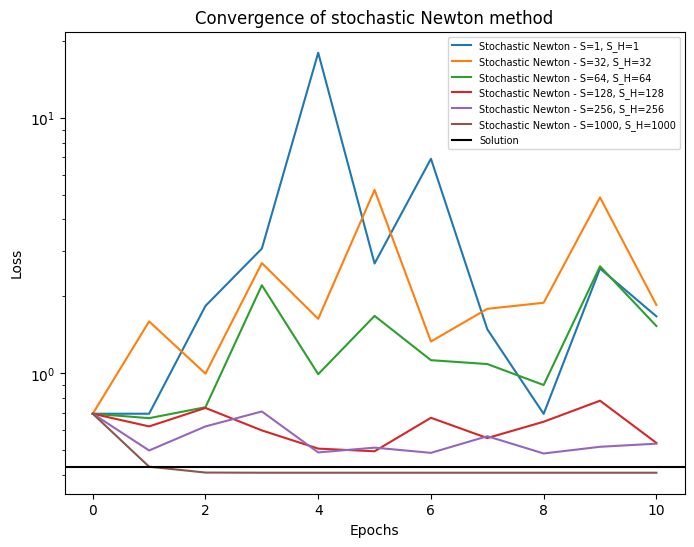

In [10]:
# 1 min

plt.figure(figsize=(8,6))
for (grad_batch_size, grad2_batch_size) in [(1,1), (32,32), (64,64), (128,128), (256,256), (N,N)] :
    print((grad_batch_size, grad2_batch_size))
    w, loss_logs, dist_logs = SubNewton(
        initial_w=initial_w,
        loss_class=loss,
        grad_batch_size=grad_batch_size,
        grad2_batch_size=grad2_batch_size,
        max_epochs=10,
        ground_truth=ground_truth,
        tolerance=1e-6,
        verbose=False,
        with_remplacement=False,
        use_line_search=True,
        c=1e-4,
        theta=0.5,
    )
    plt.plot(loss_logs, label=f"Stochastic Newton - S={grad_batch_size}, S_H={grad2_batch_size}")
    gc.collect()
plt.axhline(y=best_loss, label="Solution", color="black")
plt.title("Convergence of stochastic Newton method")
plt.legend(loc="upper right", fontsize=(7))
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

The Basic Newton method converges to the solution in 2 epochs. <br>
The higher the batch size is, the better the convergence seems to be in this situation. <br>
Notice that we started close to the actual solution, so we don't really see the advantage of stochastic methods

**So let's try again with a starting point that is further away from the solution**

In [11]:
# initial w with high variance
np.random.seed(3)
initial_w = np.random.randn(d)*10
print(initial_w[:10])

[ 17.88628473   4.36509851   0.96497468 -18.63492703  -2.77388203
  -3.54758979  -0.82741481  -6.27000677  -0.43818169  -4.7721803 ]


1 1
32 32
64 64
128 128
256 256
1000 1000
alpha too low


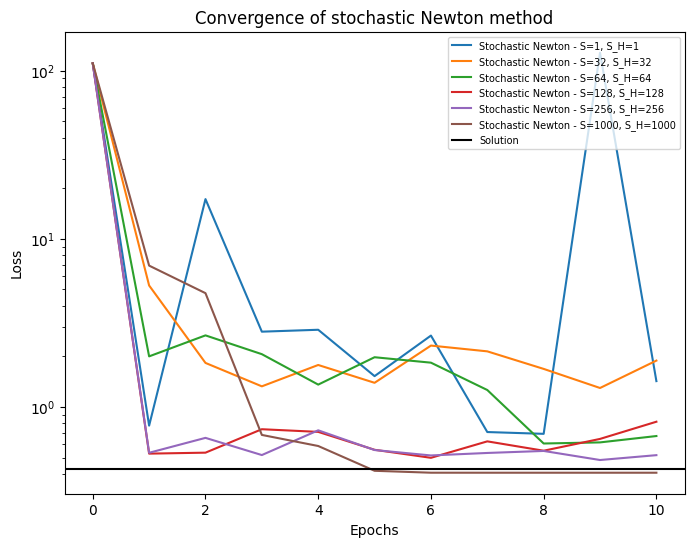

In [12]:
# 1 min

plt.figure(figsize=(8,6))
for (grad_batch_size, grad2_batch_size) in [(1,1), (32,32), (64,64), (128,128), (256,256), (N,N)] :
    print(grad_batch_size, grad2_batch_size)
    w, loss_logs, dist_logs = SubNewton(
        initial_w=initial_w,
        loss_class=loss,
        grad_batch_size=grad_batch_size,
        grad2_batch_size=grad2_batch_size,
        max_epochs=10,
        ground_truth=ground_truth,
        tolerance=1e-6,
        verbose=False,
        with_remplacement=False,
        use_line_search=True,
        c=1e-4,
        theta=0.5,
    )
    plt.plot(loss_logs, label=f"Stochastic Newton - S={grad_batch_size}, S_H={grad2_batch_size}")
    gc.collect()
plt.axhline(y=best_loss, label="Solution", color="black")
plt.title("Convergence of stochastic Newton method")
plt.legend(loc="upper right", fontsize=(7))
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

With a starting point that further away from the solution, we see that the batch stochastic method approches the solution faster at the beginning, but starts oscillating a little above the solution (as seen in the lectures for the stochastic gradient method). <br> 
Whereas the full Newton method has less variance and converges successfully at the end, but is slower at the beginning. <br>
A batch size of 128 or 256 seems to be a good tradeoff between faster early convergence/less variance

In [13]:
gc.collect()

10202

### Question 8

Fix sample sizes for the gradient and Hessian. We consider two possible stepsize choice [...]

(Storing the result for batch = 128 line search)

In [14]:
w2, loss_logs2, dist_logs2 = SubNewton(
    initial_w=initial_w,
    loss_class=loss,
    grad_batch_size=128,
    grad2_batch_size=128,
    max_epochs=30,
    ground_truth=ground_truth,
    tolerance=1e-6,
    verbose=True,
    with_remplacement=False,
    use_line_search=True
)

 epoch   |   loss   |   norm  


       0 | 1.11e+02 | 7.32e+01:   0%|          | 0/8 [00:00<?, ?it/s]

       0 | 1.11e+02 | 7.32e+01: 100%|██████████| 8/8 [00:00<00:00, 35.41it/s]
       1 | 7.79e-01 | 2.24e+00: 100%|██████████| 8/8 [00:00<00:00, 112.65it/s]
       2 | 7.88e-01 | 2.25e+00: 100%|██████████| 8/8 [00:00<00:00, 109.05it/s]
       3 | 5.33e-01 | 1.42e+00: 100%|██████████| 8/8 [00:00<00:00, 61.03it/s]
       4 | 7.95e-01 | 2.25e+00: 100%|██████████| 8/8 [00:00<00:00, 115.25it/s]
       5 | 6.53e-01 | 1.91e+00: 100%|██████████| 8/8 [00:00<00:00, 114.26it/s]
       6 | 5.74e-01 | 1.60e+00: 100%|██████████| 8/8 [00:00<00:00, 122.47it/s]
       7 | 5.40e-01 | 1.47e+00: 100%|██████████| 8/8 [00:00<00:00, 89.95it/s]
       8 | 9.43e-01 | 2.60e+00: 100%|██████████| 8/8 [00:00<00:00, 110.90it/s]
       9 | 7.35e-01 | 2.27e+00: 100%|██████████| 8/8 [00:00<00:00, 108.26it/s]
      10 | 5.08e-01 | 1.32e+00: 100%|██████████| 8/8 [00:00<00:00, 115.10it/s]
      11 | 4.98e-01 | 1.16e+00: 100%|██████████| 8/8 [00:00<00:00, 47.90it/s]
      12 | 5.28e-01 | 1.36e+00: 100%|██████████| 8/8 [00

In [15]:
L = loss.get_L()
print(L)

6.300440359156583


Running Batch_newton with $|S_k| = |S_k^H| = 128$ and constant $\alpha = \frac{1}{L}$, $\alpha = \frac{2}{L}$ <br> 
then alpha with batch L : $\alpha = \frac{1}{L_{S_k}}$, $\alpha = \frac{2}{L_{S_k}}$

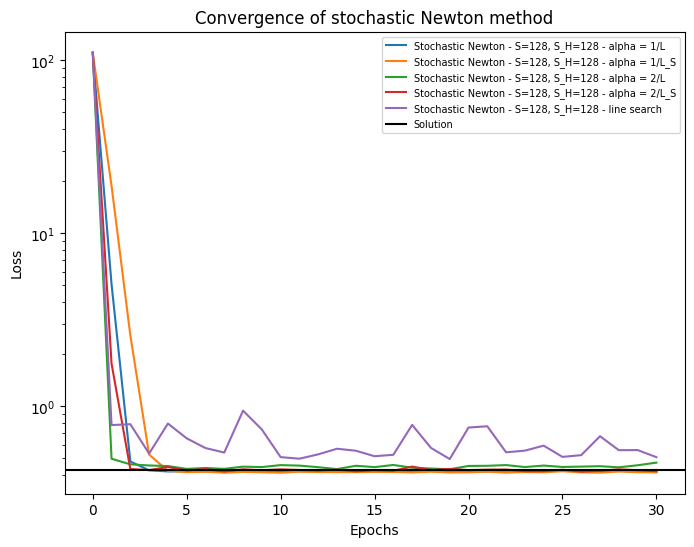

In [16]:
# 2 minutes

plt.figure(figsize=(8,6))
for alpha_zero in [1, 2]:
    # full L
    w, loss_logs, dist_logs = SubNewton(
        initial_w=initial_w,
        loss_class=loss,
        grad_batch_size=128,
        grad2_batch_size=128,
        max_epochs=30,
        ground_truth=ground_truth,
        tolerance=1e-6,
        verbose=False,
        with_remplacement=False,
        use_line_search=False,
        step_size=alpha_zero/L,
    )
    plt.plot(loss_logs, label=f"Stochastic Newton - S=128, S_H=128 - alpha = {alpha_zero}/L")
    # Batch L
    w, loss_logs, dist_logs = SubNewton(
        initial_w=initial_w,
        loss_class=loss,
        grad_batch_size=128,
        grad2_batch_size=128,
        max_epochs=30,
        ground_truth=ground_truth,
        tolerance=1e-6,
        verbose=False,
        with_remplacement=False,
        use_line_search=False,
        alpha_batch_L=alpha_zero,
    )
    plt.plot(loss_logs, label=f"Stochastic Newton - S=128, S_H=128 - alpha = {alpha_zero}/L_S")
plt.plot(loss_logs2, label=f"Stochastic Newton - S=128, S_H=128 - line search")
plt.axhline(y=best_loss, label="Solution", color="black")
plt.title("Convergence of stochastic Newton method")
plt.legend(loc="upper right", fontsize=(7))
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

- We see that the line search (with c=1e-4, theta=0.5) oscillates above the solution. It also costs more computations that we don't measure here (since we're only looking at epochs)
- with a constant step size $\alpha = \frac{\alpha_0}{L}$ or $\alpha = \frac{\alpha_0}{L_{S_k}}$, we guarantee a decrease of the objective function
- $\alpha_0 = 2$ is faster than $\alpha_0 = 1$ 
- There is no big difference between batch-computed L and constant L, the latter converges slightly faster than its counterpart.

In [17]:
gc.collect()

11312

## 2.2 Stochastic Quasi-Newton

### Implementation 2.2

In [18]:
from algorithms import get_H, get_limited_H

In [19]:
from algorithms2 import BatchBFGS, BatchLBFGS, BatchArmijoLineSearch

### Question 9

In [20]:
# Generate the problem instances - we use moderate sizes but those will serve our purpose
d = 50
N = 1000
idx = np.arange(d)
lbda = 1. / N ** (0.5)
# Gaussian initial point
initial_w = np.random.randn(d)

# Fix random seed for reproducibility
np.random.seed(1)

# actual solution of the problem
ground_truth = (-1)**idx * np.exp(-idx / 10.)


X, y = simu_linmodel(ground_truth, N, std=1., corr=0.7)
y = np.sign(y) # Taking the logarithm for binary classification

In [21]:
loss = LogisticLoss(X, y, lbda)
print("Initial loss :", loss(initial_w, np.arange(N)))
L= loss.get_L()
print("Gradient Lipschitz constant :", L)

Initial loss : 3.1387216845044574
Gradient Lipschitz constant : 23.448611245815908


In [22]:
best_loss = loss(ground_truth, np.arange(N))
print(best_loss)

0.6049051194034001


Running BFGS with batch_size=1 ...


C:\Users\huang\AppData\Local\Temp\ipykernel_46388\3661202609.py:11: RuntimeWarning: overflow encountered in exp
  obj = np.log(1 + np.exp(-self.y[i] * self.X[i].dot(w)))


Running BFGS with batch_size=32 ...
Running BFGS with batch_size=64 ...
Running BFGS with batch_size=128 ...
Running BFGS with batch_size=256 ...
Running BFGS with batch_size=512 ...
Running BFGS with batch_size=1000 ...


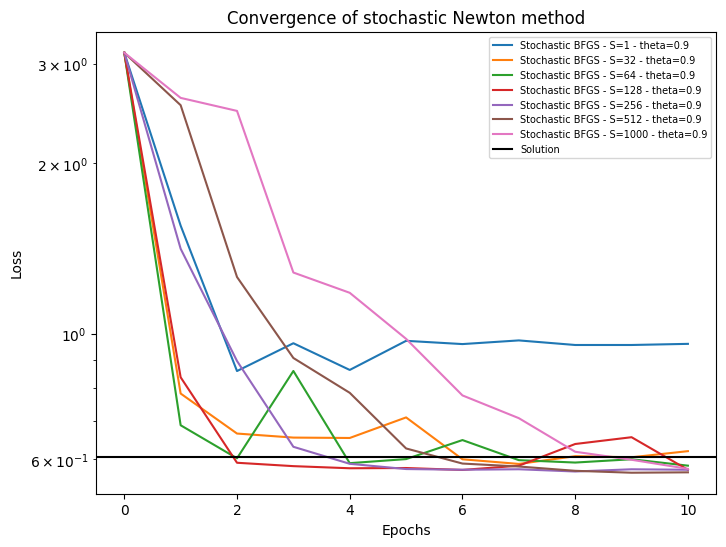

In [23]:
theta = 0.9

plt.figure(figsize=(8,6))
for batch_size in [1, 32, 64, 128, 256, 512, N]:
    print(f"Running BFGS with batch_size={batch_size} ...")
    w, loss_logs, norm_logs = BatchBFGS(
    initial_w=initial_w,
    loss_class=loss,
    grad_batch_size=batch_size,
    max_epochs=10,
    ground_truth=ground_truth,
    tolerance=1e-5,
    verbose=False,
    seed=6,
    with_remplacement=False,
    use_line_search=True,
    c=1e-4,
    theta=theta,
    )   
    plt.plot(loss_logs, label=f"Stochastic BFGS - S={batch_size} - theta={theta}")
plt.axhline(y=best_loss, label="Solution", color="black")
plt.title("Convergence of stochastic Newton method")
plt.legend(loc="best", fontsize=(7))
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

There seems to be a sweet spot for the value of the batch_size :
- 1 is too low, too much variance
- 1000 (=N) is too high, too slow
- 32 and 64 are quite fast, but they oscillate around the solution.
- any value between 128 to 512 seems good

Running L-BFGS with batch_size=1 ...
Running L-BFGS with batch_size=32 ...
Running L-BFGS with batch_size=64 ...
Running L-BFGS with batch_size=128 ...
Running L-BFGS with batch_size=256 ...
Running L-BFGS with batch_size=512 ...
Running L-BFGS with batch_size=1000 ...


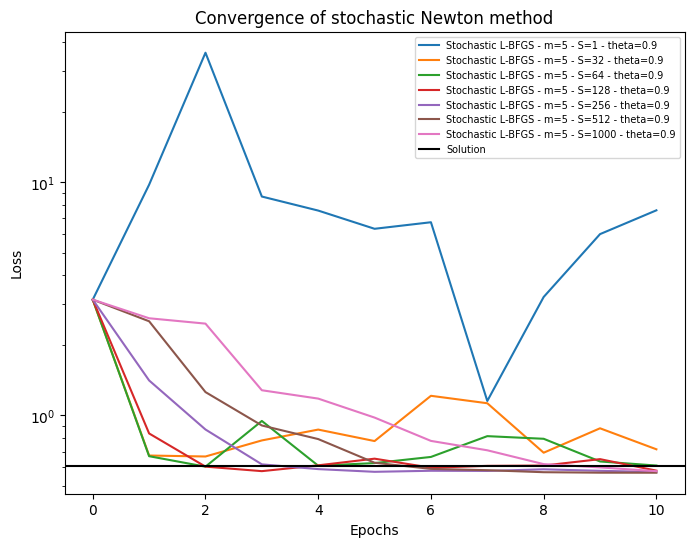

In [24]:
m = 5
theta = 0.9

plt.figure(figsize=(8,6))
for batch_size in [1, 32, 64, 128, 256, 512, N]:
    print(f"Running L-BFGS with batch_size={batch_size} ...")
    w, loss_logs, norm_logs = BatchLBFGS(
    initial_w=initial_w,
    loss_class=loss,
    grad_batch_size=batch_size,
    m=m,
    max_epochs=10,
    ground_truth=ground_truth,
    tolerance=1e-5,
    verbose=False,
    seed=6,
    with_remplacement=False,
    use_line_search=True,
    c=1e-4,
    theta=theta,
    )   
    plt.plot(loss_logs, label=f"Stochastic L-BFGS - m={m} - S={batch_size} - theta={theta}")
plt.axhline(y=best_loss, label="Solution", color="black")
plt.title("Convergence of stochastic Newton method")
plt.legend(loc="upper right", fontsize=(7))
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

L-BFGS has a little bit more variance, it makes sense because we use an approximation of H limited to the last 5 iterations (+the approximation of using a stochastic method) <br>
- Sweet spot here : batch of 128-256
- Decent : batch of 64
- Too slow : batch of N
- Too much variance : batch of 1-32

In [25]:
gc.collect()

18805